In [1]:
from ROOT import TFile, gDirectory
import ROOT as r
import os
import datetime
import numpy as np

Welcome to JupyROOT 6.16/00


In [2]:
%%time
#test if kernel is running

print('running')

running
CPU times: user 146 µs, sys: 50 µs, total: 196 µs
Wall time: 189 µs


# Todo

* [DONE]Add plots for number of b-tagged jets
* Check number of jets
* [DONE] extend MET plot range until no overflow 
* [DONE] fix ratio scaling on log plots


* get total sum weight of all the files (>2) # of weighted entries
* [DONE] fix the loops so that there is only one and add a flag for data/mc to do the weighting 
* [DONE] Create correction function of HT to get HT ratio ~1, make sure other rations remain unchanged, use tf1 fit or roofit
* [DONE] evaluate function of HT by making ratio comparison plots for the mc original and mc corrected
* [DONE]consider cutting off the function fit at certain HT value and flat after or adjusting bin sizes to reduce uncertainty, then fit 
* [DONE] plot signal and background on same plot and look for critical values for seperation - these are to be used as cuts later

# Cuts
* high ht - must look at signal to know
* large # of b jets (test 3 and 4)
* large # of jets
* for each cut, calcualte signal / sqrt(signal + bkg) (psudo-significance) and find cut to maximize this value 
* look at distributions by normalizing both to one (a first order approx)


# Outline of Notebook
* All function defns
* Initlalize chains and hists
* Build correction function from ht
* Refill new corrected histograms
* Make good cuts based on bkg ONLY
* Plot signal and bkg hists


Significance is ratio by which signal is ibgger than poisson flucuations

Build files into TChain

# FUNCTIONS

In [3]:
#use lum = 140
def GetWeight(lumi,tree, corr_poly = None):
    #w = lumi * 1000 * tree.weight_normalise *  tree.weight_mc *  tree.weight_pileup *tree.weight_leptonSF *  tree.weight_bTagSF_MV2c10_77 *  tree.weight_jvt
    w = ((43.5938/127.64416)*(tree.runNumber == 300000)+(36.20766/127.64416)*(tree.runNumber == 284500)+(47.8427/127.64416)*(tree.runNumber == 310000))*tree.weight_normalise*tree.weight_mc*tree.weight_pileup*tree.weight_leptonSF*tree.weight_bTagSF_MV2c10_70*127.65516*1000*(tree.nBTags_MV2c10_70>1)
    
    if corr_poly:
        w_ht_corrected = w / corr_poly.Eval(tree.HT_all)
        return w_ht_corrected
   
    else: return w

def poly_ht(func, ht):
    return func.Eval(ht)

In [4]:
def fill_hists(chain, entries, run_type, poly= None, save_hists = False, cuts =['bjets_mc70 <= 2']):
    
    for cut in cuts:
        print(cut)
    for jentry in range(entries):
        
        if jentry%100000 == 0: print('Entry ' + str(jentry) +'/' + str(entries))
        nb = chain.GetEntry(jentry)
    
        if nb<=0: continue
        
        jet_pt = chain.jet_pt[0]
        met = chain.met_met
        #mu_pt = mc_chain.mu_pt
        ht_all = chain.HT_all
        bjets_mc70 = chain.nBTags_MV2c10_70
        njets = chain.nJets

        
        #add conditions here
        conditions = False
        for cut in cuts:
            if eval(cut) == True: 
                conditions = True
        #if (bjets_mc70 < 2): continue
        if conditions == True: continue
     
      
        if run_type == 'data': 
            met_data.Fill(met)
            jet_pt_data.Fill(jet_pt)
            ht_all_data.Fill(ht_all)
            bjets_data.Fill(bjets_mc70)
            njets_data.Fill(njets)

        elif run_type == 'bkg_corr':
            try:
                weight = GetWeight(140, chain, corr_poly = poly)
            except:
                print("MC corrected requires a function to exectute")
                break
                
            met_bkg_corr.Fill(met,weight)
            jet_pt_bkg_corr.Fill(jet_pt, weight)
            ht_all_bkg_corr.Fill(ht_all, weight)
            bjets_bkg_corr.Fill(bjets_mc70, weight)
            njets_bkg_corr.Fill(njets, weight)
            
        elif run_type == 'signal':
            weight = GetWeight(140, chain)
            
            met_sig.Fill(met, weight)
            ht_all_sig.Fill(ht_all, weight)
            jet_pt_sig.Fill(jet_pt, weight)
            bjets_sig.Fill(bjets_mc70, weight)
            njets_sig.Fill(njets, weight)
             
        elif run_type == 'bkg':
            weight = GetWeight(140, chain)
            
            met_bkg.Fill(met,weight)
            jet_pt_bkg.Fill(jet_pt, weight)
            ht_all_bkg.Fill(ht_all, weight)
            bjets_bkg.Fill(bjets_mc70, weight)
            njets_bkg.Fill(njets, weight)
            
    if save_hists == True:
        time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
        if run_type == 'data':
            met_data.SaveAs('met_data_' + time + '.root')
            jet_pt_data.SaveAs('jetpt_data_' + time + '.root')
            ht_all_data.SaveAs('htall_data_' + time + '.root')
            bjets_data.SaveAs('bjets_data_' + time + '.root')
            njets_data.SaveAs('njets_data_'+time+'.root')
            
        elif run_type == 'bkg_corr':
            met_bkg_corr.SaveAs('met_bkg_corr_' + time + '.root')
            jet_pt_bkg_corr.SaveAs('jetpt_bkg_corr_' + time + '.root')
            ht_all_bkg_corr.SaveAs('htall_bkg_corr_' + time + '.root')
            bjets_bkg_corr.SaveAs('bjets_bkg_corr_' + time + '.root')
            njets_bkg_corr.SaveAs('njets_bkg_corr_' + time + '.root')
            
        elif run_type == 'signal':
            met_sig.SaveAs('met_sig_' +time+'.root')
            jet_pt_sig.SaveAs('jetpt_sig_' +time+'.root')
            ht_all_sig.SaveAs('htall_sig_' +time+'.root')
            bjets_sig.SaveAs('bjets_sig_' +time+'.root')
            njets_sig.SaveAs('njets_sig_' +time+'.root')
            
        elif run_type == 'bkg':
            met_bkg.SaveAs('met_bkg_' + time + '.root')
            jet_pt_bkg.SaveAs('jetpt_bkg_' + time + '.root')
            ht_all_bkg.SaveAs('htall_bkg_' + time + '.root')
            bjets_bkg.SaveAs('bjets_bkg_' + time + '.root')
            njets_bkg.SaveAs('njets_bkg_'+time+'.root')

In [8]:
def make_ratio_hists(bkg_hist, data_hist, save_name, draw = True , log = False):
    c = r.TCanvas()
    
    rp = r.TRatioPlot(bkg_hist, data_hist)
    rp.Draw()

    if log == True:
        c.SetLogy(1)
    lower_y = rp.GetLowerRefYaxis()
    
    lower_y.SetTitle('MC/Data')
    lower_y.SetRangeUser(0,2)

    if draw == True:
        c.Draw()
        
    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def make_ratio_compare_hists(mc_original, mc_corr_original, data, save_name, draw = True, title = ''):
    
    c = r.TCanvas()
        
    mc = mc_original.Clone()
    mc_corr = mc_corr_original.Clone()
    
    
    mc.Divide(data)
    mc_corr.Divide(data)
    
    mc_corr.SetLineColor(4)
    mc_corr.Draw()
    mc.SetLineColor(2)
    mc.Draw("SAME")
    
    legend = r.TLegend()
    legend.AddEntry(mc, "Original Ratio")
    legend.AddEntry(mc_corr, "H^{T} Corrected Ratio")
    
    legend.Draw()
    
    mc_corr.SetTitle(title + ' H^{T}-Corrected MC Ratio')
    mc_corr.SetYTitle('MC/Data')
    mc_corr.SetXTitle('[MeV]')
    
    if draw== True:
        c.Draw()

    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def test_corr_fn(data_chain, mc_chain):
    
    fill_hists(data_chain, data_entries, run_type = 'data', poly = None,cuts=['bjets_mc70 != 2'])
    fill_hists(bkg_chain, bkg_entries, run_type = 'bkg', poly = None,cuts=['bjets_mc70 != 2'])
    
    #clone ht_all, call divide from data, fit divided, pass fn to corr_hists
    ht_ratio = ht_all_bkg.Clone()
    
    ht_ratio.Divide(ht_all_data)
    
    ht_ratio.Fit('pol5','S')
    
    ht_fit = ht_ratio.GetFunction('pol5')
                                                                           
                                                                         
    ht_ratio.SaveAs('fit_hist_n2'+ datetime.datetime.now().strftime("%y-%m-%d+%H_%M")+ '.root')
    
    fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = ht_fit, save_hists=True)
    
    return ht_ratio

def make_sig_bkg_stack(bkg_hist, sig_hist, save_fname , title = ''):
    stack = r.THStack()
    bkg_hist.SetLineColor(4)
    sig_hist.SetLineColor(2)
    bkg_hist.SetYTitle('Events')
    bkg_hist.SetTitle(title)
    l = r.TLegend()
    l.AddEntry(bkg_hist, 'Bkg')
    l.AddEntry(sig_hist, 'Signal')
    stack.Add(bkg_hist)
    stack.Add(sig_hist)
    
    
    
    stack.SaveAs(save_fname + '.root')
    

# Initilization

## Initilize Chains

In [6]:
%%time
filename = 'ttbar_nonallhad_HF_PhPy8_AFII_mc16a.root'
treename = 'nominal_Loose'

list_of_files = os.listdir('../data_ttbar/')
data_files = [f for f in list_of_files if 'data' in f]
bkg_files = [ 'ttbar_nonallhad_incl_PhPy8_AFII_mc16a.root', 'ttbar_nonallhad_incl_PhPy8_AFII_mc16d.root','ttbar_nonallhad_incl_PhPy8_AFII_mc16e.root',
            'ttX_mc16e.root','ttX_mc16d.root','ttX_mc16a.root',
            'vjets_Sherpa_mc16e.root','vjets_Sherpa_mc16d.root', 'vjets_Sherpa_mc16a.root',
            'singleTop_mc16e.root','singleTop_mc16d.root','singleTop_mc16a.root',
            'multiV_mc16a.root','multiV_mc16d.root','multiV_mc16e.root']

signal_files = ['4tops_Mg5Py8_AFII_mc16a.root','4tops_Mg5Py8_AFII_mc16d.root','4tops_Mg5Py8_AFII_mc16e.root']
#data_files = ['data15_AllYear.root']
#mc_files = ['ttbar_nonallhad_HF_PhPy8_AFII_mc16d.root']

data_chain = r.TChain(treename)
bkg_chain = r.TChain(treename)
signal_chain = r.TChain(treename)

for f in data_files:
    data_chain.Add('../data_ttbar/'+f)
for f in bkg_files:
    bkg_chain.Add('../data_ttbar/'+ f)
for f in signal_files:
    signal_chain.Add('../data_ttbar/'+ f)

data_entries = data_chain.GetEntries()
bkg_entries = bkg_chain.GetEntries()
signal_entries = signal_chain.GetEntries()

print(f'There are: \n{data_entries} data events \n{bkg_entries} mc events \n{signal_entries} signal events \n\n')



There are: 
3223533 data events 
23130773 mc events 
3661752 signal events 


CPU times: user 180 ms, sys: 29.1 ms, total: 209 ms
Wall time: 237 ms


## Initialize histograms

In [7]:
#####
#Set Up Code
#####

#mc_corr are mc background filled with ht-corrected weight
#mc are mc background filled with uncorrected weight
#data are data files

met_bkg = r.TH1D('met_bkg', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_bkg_corr = r.TH1D('met_bkg_corr', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_data = r.TH1D('met_data', 'E^T_{miss}', 100, 0, 1.2*10**6)
met_sig = r.TH1D('met_sig', 'E^T_{miss}', 100, 0, 1.2*10**6)

jet_pt_data = r.TH1D('jet_pt_data', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_bkg = r.TH1D('jet_pt_bkg', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_bkg_corr = r.TH1D('jet_pt_bkg_corr', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_sig = r.TH1D('jet_pt_sig', 'jet_{pt}', 100, 0, 2*10**6)

ht_all_bkg = r.TH1D('ht_all_bkg', 'H_{t}', 100, 0, 6000*10**3)
ht_all_bkg_corr = r.TH1D('ht_all_bkg_corr', 'H_{t}', 100, 0, 6000*10**3)
ht_all_data = r.TH1D('ht_all_data', '\H_{t}', 100, 0, 6000*10**3)
ht_all_sig = r.TH1D('ht_all_sig', '\H_{t}', 100, 0, 6000*10**3)

bjets_bkg = r.TH1D('bjets_bkg', 'Number of B Jets', 11,0,11)
bjets_bkg_corr = r.TH1D('bjets_bkg_corr', 'Number of B Jets', 11,0,11)
bjets_data = r.TH1D('bjets_data', 'Number of B Jets', 11,0,11)
bjets_sig = r.TH1D('bjets_sig', 'Number of B Jets', 11,0,11)

njets_bkg = r.TH1D('njets_bkg', 'Number of Jets', 20,0,20)
njets_data = r.TH1D('njets_data', 'Number of Jets', 20,0,20)
njets_sig = r.TH1D('njets_sig', 'Number of Jets', 20,0,20)
njets_bkg_corr = r.TH1D('njets_bkg_corr', 'Number of Jets', 20,0,20)

 # Fill histograms

In [8]:
fill_hists(data_chain, data_entries, run_type = 'data', poly = None)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg', poly = None)

bjets_mc70 <= 2
Entry 0/3223533
Entry 100000/3223533
Entry 200000/3223533
Entry 300000/3223533
Entry 400000/3223533
Entry 500000/3223533
Entry 600000/3223533
Entry 700000/3223533
Entry 800000/3223533
Entry 900000/3223533
Entry 1000000/3223533
Entry 1100000/3223533
Entry 1200000/3223533
Entry 1300000/3223533
Entry 1400000/3223533
Entry 1500000/3223533
Entry 1600000/3223533
Entry 1700000/3223533
Entry 1800000/3223533
Entry 1900000/3223533
Entry 2000000/3223533
Entry 2100000/3223533
Entry 2200000/3223533
Entry 2300000/3223533
Entry 2400000/3223533
Entry 2500000/3223533
Entry 2600000/3223533
Entry 2700000/3223533
Entry 2800000/3223533
Entry 2900000/3223533
Entry 3000000/3223533
Entry 3100000/3223533
Entry 3200000/3223533
bjets_mc70 <= 2
Entry 0/23130773
Entry 100000/23130773
Entry 200000/23130773
Entry 300000/23130773
Entry 400000/23130773
Entry 500000/23130773
Entry 600000/23130773
Entry 700000/23130773
Entry 800000/23130773
Entry 900000/23130773
Entry 1000000/23130773
Entry 1100000/23130

In [10]:
make_ratio_hists(njets_bkg, njets_data,'njets_rp_log')

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 7 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file njets_rp_log.root has been created


In [8]:
%%time
hist_ratio = test_corr_fn(data_chain, bkg_chain)
fit_fn = hist_ratio.GetFunction('pol5')


fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, poly = fit_fn)

bjets_mc70 != 2
Entry 0/3223533
Entry 10000/3223533
Entry 20000/3223533
Entry 30000/3223533
Entry 40000/3223533
Entry 50000/3223533
Entry 60000/3223533
Entry 70000/3223533
Entry 80000/3223533
Entry 90000/3223533
Entry 100000/3223533
Entry 110000/3223533
Entry 120000/3223533
Entry 130000/3223533
Entry 140000/3223533
Entry 150000/3223533
Entry 160000/3223533
Entry 170000/3223533
Entry 180000/3223533
Entry 190000/3223533
Entry 200000/3223533
Entry 210000/3223533
Entry 220000/3223533
Entry 230000/3223533
Entry 240000/3223533
Entry 250000/3223533
Entry 260000/3223533
Entry 270000/3223533
Entry 280000/3223533
Entry 290000/3223533
Entry 300000/3223533
Entry 310000/3223533
Entry 320000/3223533
Entry 330000/3223533
Entry 340000/3223533
Entry 350000/3223533
Entry 360000/3223533
Entry 370000/3223533
Entry 380000/3223533
Entry 390000/3223533
Entry 400000/3223533
Entry 410000/3223533
Entry 420000/3223533
Entry 430000/3223533
Entry 440000/3223533
Entry 450000/3223533
Entry 460000/3223533
Entry 47000

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TH1D::SaveAs>: ROOT file fit_hist_n219-05-01+01_08.root has been created
Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-05-01+01_35.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-05-01+01_35.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-05-01+01_35.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-05-01+01_35.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-05-01+01_35.root has been created
Info in <TH1D::SaveAs>: ROOT file met_sig_19-05-01+01_40.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-05-01+01_40.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-05-01+01_40.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-05-01+01_40.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-05-01+01_40.root has been created


In [9]:
make_ratio_compare_hists(mc_original=ht_all_bkg, mc_corr_original=ht_all_bkg_corr, data=ht_all_data, save_name='ratio_compare_ht', title = 'H^{T}')

In [39]:
make_ratio_compare_hists(mc_original=ht_all_bkg, mc_corr_original=ht_all_bkg_corr, data=ht_all_data, save_name='ratio_compare_ht', title = 'H^{T}')

Info in <TCanvas::SaveAs>: ROOT file ratio_compare_ht.root has been created



****************************************
Minimizer is Linear
Chi2                      =      83.0729
NDf                       =           58
p0                        =     0.870924   +/-   0.0103747   
p1                        =  4.82084e-07   +/-   6.87341e-08 
p2                        = -6.70283e-13   +/-   1.55617e-13 
p3                        =  5.75599e-19   +/-   1.48243e-19 
p4                        = -1.87566e-25   +/-   5.933e-26   
p5                        =   1.9071e-32   +/-   8.05172e-33 


Info in <TH1D::SaveAs>: ROOT file ht_fit_correct.root has been created
Info in <TH1D::SaveAs>: C++ Macro file: ht_fit_correct.png has been generated


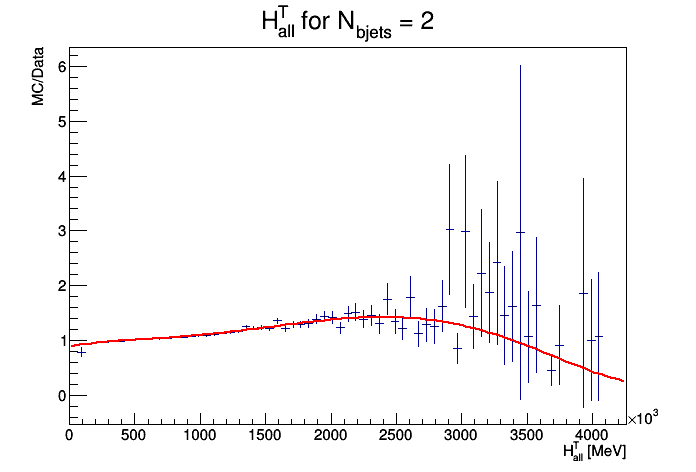

In [12]:
f_ratio = r.TFile('fit_hist_n219-05-01+01_08.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')

h_test = h_ratio.Clone()
h_test.GetFunction('pol5').Delete()
h_test.SetAxisRange(0, 4250*10**3)
fit_new = h_test.Fit('pol5','S')
h_test.SetTitle('H^{T}_{all} for N_{bjets} = 2')
h_test.SetXTitle('H^{T}_{all} [MeV]')
h_test.SetYTitle('MC/Data')
h_test.SetStats(0)
h_test.SaveAs('ht_fit_correct.root')
h_test.SaveAs('ht_fit_correct.png')
c3= r.TCanvas()

h_test.Draw()


c3.Draw()

In [10]:
make_ratio_compare_hists(jet_pt_bkg, jet_pt_bkg_corr, jet_pt_data,'jet_pt_ratio', draw=False)
make_ratio_compare_hists(met_bkg, met_bkg_corr, met_data,'met_ratio', draw=False)
make_ratio_compare_hists(ht_all_bkg, ht_all_bkg_corr, ht_all_data,'ht_all_ratio', draw=False)
make_ratio_compare_hists(bjets_bkg, bjets_bkg_corr, bjets_data,'bjets_ratio', draw=False)

Info in <TCanvas::SaveAs>: ROOT file jet_pt_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file met_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file ht_all_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file bjets_ratio.root has been created


# Finding Optimal Cuts

In [11]:
def find_opt_cut(file):
    f = r.TFile(file)
    stack = f.Get(";1")
    
    f.Close()
    hists = stack.GetHists()
    
    bkg, sig = hists
    bkg.SetDirectory(0)
    sig.SetDirectory(0)
    
    
    bins = bkg.GetNbinsX()
    
    best_cut = 0
    best_min = None
    
    plot_cut = []
    plot_min = []
    for min_bin in range(bins):
        #for max_bin in bins:
        max_bin = bins
        bkg_int = bkg.Integral(min_bin, max_bin)
        sig_int = sig.Integral(min_bin, max_bin)

        cut = sig_int / np.sqrt(sig_int + bkg_int)

        plot_cut.append(cut)
        plot_min.append(bkg.GetXaxis().GetBinLowEdge(min_bin))
        if cut > best_cut:
            best_cut = cut
            best_min = min_bin
            
    with open(file+'_output.txt', 'w') as out_file:
        for s in zip(plot_min, plot_cut):
            out_file.write(str(s[0])+ ',' + str(s[1])+ '\n')
    
    print('Cut at', bkg.GetXaxis().GetBinLowEdge(best_min),'for significance =', best_cut)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def plot_cut_efficiency(file, unit="", title="", save_name=None):
    data = pd.read_csv(file, header = None)
    plt.plot(data[0], data[1])
    plt.xlabel('Cut Value' + ' ['+ unit+']')
    plt.ylabel('Significance')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    locs, labels = plt.xticks()
    
    
    if unit=='MeV'or unit =='GeV':
        loc_new = [int(loc/1000) for loc in locs]
        plt.xticks(locs, loc_new)
    
    
    if save_name:
        plt.savefig(save_name + '.png')

In [13]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

#fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True)
#fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, poly = fit_fn)
#fill_hists(data_chain, data_entries, run_type = 'data', poly = None)
#fill_hists(bkg_chain, bkg_entries, run_type = 'bkg', poly = None)


f1  = r.TFile('met_bkg_corr_19-05-01+05_05.root')
met_bkg_corr = f1.Get('met_bkg_corr;1')
f2 = r.TFile('met_sig_19-05-01+04_32.root')
met_sig = f2.Get('met_sig;1')

f3 = r.TFile('jetpt_bkg_corr_19-05-01+05_05.root')
jet_pt_bkg_corr =  f3.Get('jet_pt_bkg_corr;1')
f4 = r.TFile('jetpt_sig_19-05-01+04_32.root')
jet_pt_sig =  f4.Get('jet_pt_sig;1')


f5 =  r.TFile('htall_bkg_corr_19-05-01+05_05.root')
ht_all_bkg_corr = f5.Get('ht_all_bkg_corr;1')
f6 = r.TFile('htall_sig_19-05-01+04_32.root')
ht_all_sig = f6.Get('ht_all_sig;1')

f7 = r.TFile('bjets_bkg_corr_19-05-01+05_05.root')
bjets_bkg_corr = f7.Get('bjets_bkg_corr;1')
f8 = r.TFile('bjets_sig_19-05-01+04_32.root')
bjets_sig = f8.Get('bjets_sig;1')

f9 = r.TFile('njets_sig_19-05-01+04_32.root')
njets_sig = f9.Get('njets_sig;1')
f10 = r.TFile('njets_bkg_corr_19-05-01+05_05.root')
njets_bkg_corr = f10.Get('njets_bkg_corr;1')



for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    print(var)
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var} Sig and Bkg")'
    exec(eval_string)

met
jet_pt
ht_all
bjets
njets
CPU times: user 6.92 ms, sys: 5.21 ms, total: 12.1 ms
Wall time: 12.6 ms


Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-05-01+16_50.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-05-01+16_50.root has been created
Info in <THStack::SaveAs>: ROOT file ht_all_sig_bkg_19-05-01+16_50.root has been created
Info in <THStack::SaveAs>: ROOT file bjets_sig_bkg_19-05-01+16_50.root has been created
Info in <THStack::SaveAs>: ROOT file njets_sig_bkg_19-05-01+16_50.root has been created


In [ ]:
f11 = r.TFile('njets_sig_19-05-01+01_40.root')
njets_sig = f9.Get('njets_sig;1')
f10 = r.TFile('njets_bkg_corr_19-05-01+01_35.root')
njets_bkg_corr = f10.Get('njets_bkg_corr;1')

In [25]:
find_opt_cut('met_sig_bkg_19-05-01+02_04.root')

Cut at 36000.0 for significance = 0.3814836595325664


In [26]:
find_opt_cut('jet_pt_sig_bkg_19-05-01+02_04.root')

Cut at 140000.0 for significance = 0.4499136425151501


In [27]:
find_opt_cut('ht_all_sig_bkg_19-05-01+02_04.root')

Cut at 720000.0 for significance = 0.6607165716241568


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [28]:
find_opt_cut('bjets_sig_bkg_19-05-01+02_04.root')

Cut at 4.0 for significance = 0.4198985610540658


In [29]:
find_opt_cut('njets_sig_bkg_19-05-01+02_04.root')

Cut at 9.0 for significance = 0.9774404816393949


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


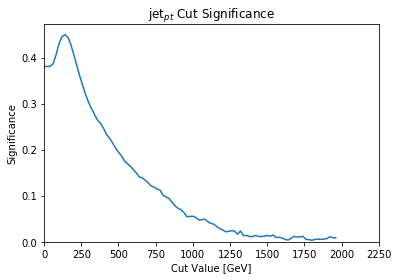

In [2]:
plot_cut_efficiency('jet_pt_sig_bkg_19-05-01+02_04.root_output.txt',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif0' )

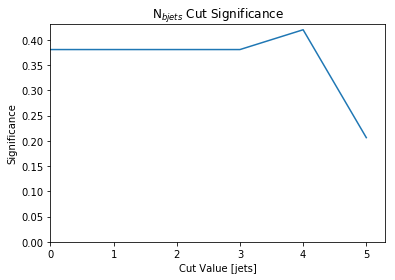

In [3]:
plot_cut_efficiency('bjets_sig_bkg_19-05-01+02_04.root_output.txt',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif0')

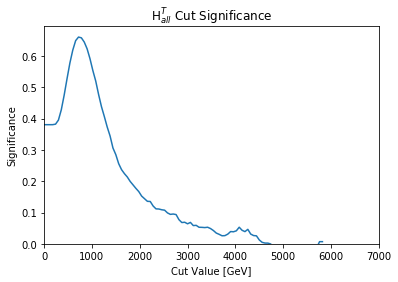

In [6]:
plot_cut_efficiency('ht_all_sig_bkg_19-05-01+02_04.root_output.txt',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif0')

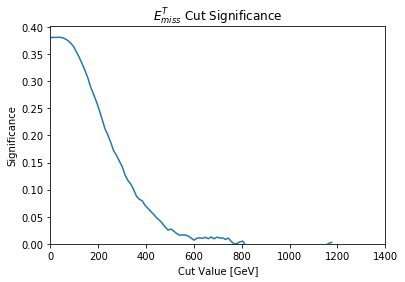

In [7]:
plot_cut_efficiency('met_sig_bkg_19-05-01+02_04.root_output.txt', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif0')

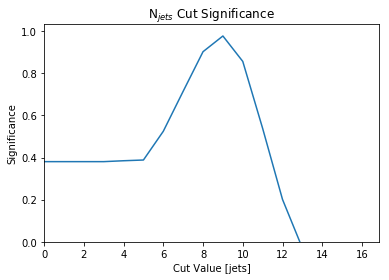

In [5]:
plot_cut_efficiency('njets_sig_bkg_19-05-01+02_04.root_output.txt', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif0')

# AFTER FIRST CUT (CUT ON NJETS)

In [8]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

cut1 = ['bjets_mc70 <=2', 'njets < 9']
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, cuts = cut1, poly=fit_fn)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True, cuts=cut1)

bjets_mc70 <=2
njets < 9
Entry 0/3661752
Entry 100000/3661752
Entry 200000/3661752
Entry 300000/3661752
Entry 400000/3661752
Entry 500000/3661752
Entry 600000/3661752
Entry 700000/3661752
Entry 800000/3661752
Entry 900000/3661752
Entry 1000000/3661752
Entry 1100000/3661752
Entry 1200000/3661752
Entry 1300000/3661752
Entry 1400000/3661752
Entry 1500000/3661752
Entry 1600000/3661752
Entry 1700000/3661752
Entry 1800000/3661752
Entry 1900000/3661752
Entry 2000000/3661752
Entry 2100000/3661752
Entry 2200000/3661752
Entry 2300000/3661752
Entry 2400000/3661752
Entry 2500000/3661752
Entry 2600000/3661752
Entry 2700000/3661752
Entry 2800000/3661752
Entry 2900000/3661752
Entry 3000000/3661752
Entry 3100000/3661752
Entry 3200000/3661752
Entry 3300000/3661752
Entry 3400000/3661752
Entry 3500000/3661752
Entry 3600000/3661752
bjets_mc70 <=2
njets < 9
Entry 0/23130773
Entry 100000/23130773
Entry 200000/23130773
Entry 300000/23130773
Entry 400000/23130773
Entry 500000/23130773
Entry 600000/23130773
En

Info in <TH1D::SaveAs>: ROOT file met_sig_19-05-01+02_16.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-05-01+02_16.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-05-01+02_16.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-05-01+02_16.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-05-01+02_16.root has been created
Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-05-01+02_42.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-05-01+02_42.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-05-01+02_42.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-05-01+02_42.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-05-01+02_42.root has been created


In [9]:
for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-05-01+02_47.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-05-01+02_47.root has been created
Info in <THStack::SaveAs>: ROOT file ht_all_sig_bkg_19-05-01+02_47.root has been created
Info in <THStack::SaveAs>: ROOT file bjets_sig_bkg_19-05-01+02_47.root has been created
Info in <THStack::SaveAs>: ROOT file njets_sig_bkg_19-05-01+02_47.root has been created


In [12]:
find_opt_cut('met_sig_bkg_19-05-01+02_47.root')

Cut at -12000.0 for significance = 0.9774827850887637


In [13]:
find_opt_cut('jet_pt_sig_bkg_19-05-01+02_47.root')

Cut at 80000.0 for significance = 0.9824444724533882


In [14]:
find_opt_cut('ht_all_sig_bkg_19-05-01+02_47.root')

Cut at 660000.0 for significance = 1.0077545816891034


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [15]:
find_opt_cut('bjets_sig_bkg_19-05-01+02_47.root')

Cut at -1.0 for significance = 0.9774709973329548


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [16]:
find_opt_cut('njets_sig_bkg_19-05-01+02_47.root')

Cut at -1.0 for significance = 0.9774404816393949


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


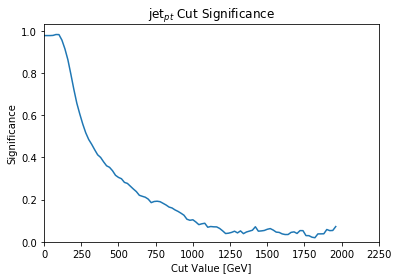

In [2]:
plot_cut_efficiency('jet_pt_sig_bkg_19-05-01+02_47.root_output.txt',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif1' )

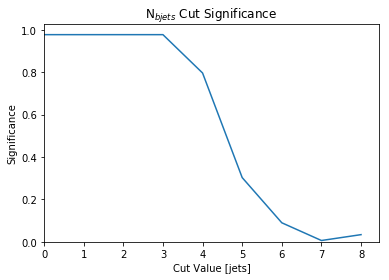

In [4]:
plot_cut_efficiency('bjets_sig_bkg_19-05-01+02_47.root_output.txt',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif1')

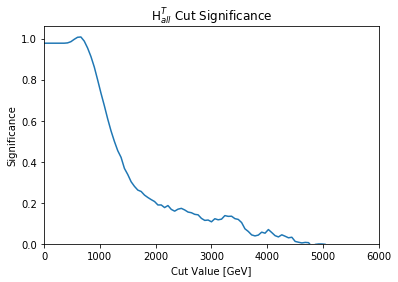

In [5]:
plot_cut_efficiency('ht_all_sig_bkg_19-05-01+02_47.root_output.txt',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif1')

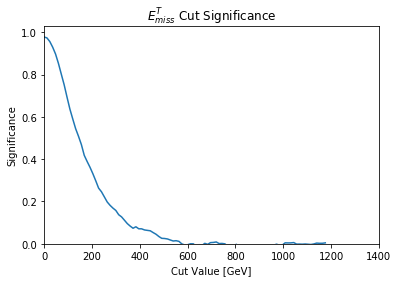

In [6]:
plot_cut_efficiency('met_sig_bkg_19-05-01+02_47.root_output.txt', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif1')

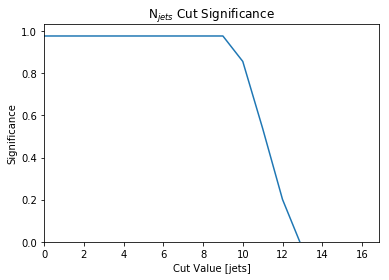

In [3]:
plot_cut_efficiency('njets_sig_bkg_19-05-01+02_47.root_output.txt', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif1')

# AFTER SECOND CUT (CUT ON XX)

In [8]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

cut2 = ['bjets_mc70 <=2', 'njets < 9', 'ht_all < 660000.0']
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, cuts = cut2, poly=fit_fn)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True, cuts=cut2)

bjets_mc70 <=2
njets < 9
ht_all < 660000.0
Entry 0/3661752
Entry 100000/3661752
Entry 200000/3661752
Entry 300000/3661752
Entry 400000/3661752
Entry 500000/3661752
Entry 600000/3661752
Entry 700000/3661752
Entry 800000/3661752
Entry 900000/3661752
Entry 1000000/3661752
Entry 1100000/3661752
Entry 1200000/3661752
Entry 1300000/3661752
Entry 1400000/3661752
Entry 1500000/3661752
Entry 1600000/3661752
Entry 1700000/3661752
Entry 1800000/3661752
Entry 1900000/3661752
Entry 2000000/3661752
Entry 2100000/3661752
Entry 2200000/3661752
Entry 2300000/3661752
Entry 2400000/3661752
Entry 2500000/3661752
Entry 2600000/3661752
Entry 2700000/3661752
Entry 2800000/3661752
Entry 2900000/3661752
Entry 3000000/3661752
Entry 3100000/3661752
Entry 3200000/3661752
Entry 3300000/3661752
Entry 3400000/3661752
Entry 3500000/3661752
Entry 3600000/3661752
bjets_mc70 <=2
njets < 9
ht_all < 660000.0
Entry 0/23130773
Entry 100000/23130773
Entry 200000/23130773
Entry 300000/23130773
Entry 400000/23130773
Entry 5000

Info in <TH1D::SaveAs>: ROOT file met_sig_19-05-01+03_01.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-05-01+03_01.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-05-01+03_01.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-05-01+03_01.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-05-01+03_01.root has been created
Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-05-01+03_31.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-05-01+03_31.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-05-01+03_31.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-05-01+03_31.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-05-01+03_31.root has been created


In [9]:
for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-05-01+04_18.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-05-01+04_18.root has been created
Info in <THStack::SaveAs>: ROOT file ht_all_sig_bkg_19-05-01+04_18.root has been created
Info in <THStack::SaveAs>: ROOT file bjets_sig_bkg_19-05-01+04_18.root has been created
Info in <THStack::SaveAs>: ROOT file njets_sig_bkg_19-05-01+04_18.root has been created


In [13]:
find_opt_cut('met_sig_bkg_19-05-01+04_18.root')

Cut at -12000.0 for significance = 1.0077623117181418


In [14]:
find_opt_cut('jet_pt_sig_bkg_19-05-01+04_18.root')

Cut at 60000.0 for significance = 1.0077283920390971


In [15]:
find_opt_cut('ht_all_sig_bkg_19-05-01+04_18.root')

Cut at -60000.0 for significance = 1.0077545816891034


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [16]:
find_opt_cut('bjets_sig_bkg_19-05-01+04_18.root')

Cut at -1.0 for significance = 1.0077491294546792


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [17]:
find_opt_cut('njets_sig_bkg_19-05-01+04_18.root')

Cut at -1.0 for significance = 1.0077151628991636


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [18]:
plot_cut_efficiency('',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif2' )

NameError: name 'plot_cut_efficiency' is not defined

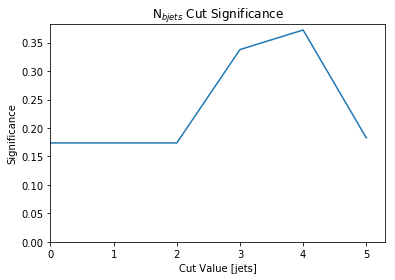

In [61]:
plot_cut_efficiency('',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif2')

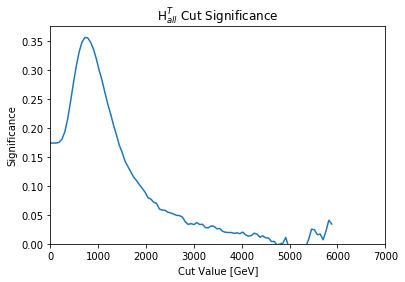

In [62]:
plot_cut_efficiency('',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif2')

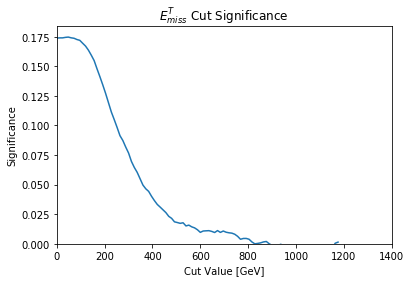

In [63]:
plot_cut_efficiency('', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif2')

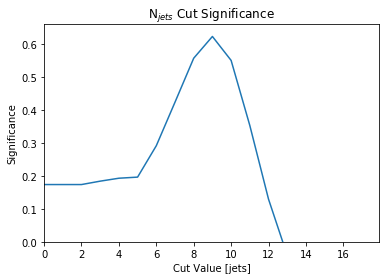

In [64]:
plot_cut_efficiency('', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif2')

# AFTER THIRD CUT (CUT ON XX)

In [8]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

cut3 = ['bjets_mc70 <=2', 'njets < 9', 'ht_all < 660000.0', 'jet_pt < 60000.0' ]
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, cuts = cut3, poly=fit_fn)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True, cuts=cut3)

bjets_mc70 <=2
njets < 9
ht_all < 660000.0
jet_pt < 60000.0
Entry 0/3661752
Entry 100000/3661752
Entry 200000/3661752
Entry 300000/3661752
Entry 400000/3661752
Entry 500000/3661752
Entry 600000/3661752
Entry 700000/3661752
Entry 800000/3661752
Entry 900000/3661752
Entry 1000000/3661752
Entry 1100000/3661752
Entry 1200000/3661752
Entry 1300000/3661752
Entry 1400000/3661752
Entry 1500000/3661752
Entry 1600000/3661752
Entry 1700000/3661752
Entry 1800000/3661752
Entry 1900000/3661752
Entry 2000000/3661752
Entry 2100000/3661752
Entry 2200000/3661752
Entry 2300000/3661752
Entry 2400000/3661752
Entry 2500000/3661752
Entry 2600000/3661752
Entry 2700000/3661752
Entry 2800000/3661752
Entry 2900000/3661752
Entry 3000000/3661752
Entry 3100000/3661752
Entry 3200000/3661752
Entry 3300000/3661752
Entry 3400000/3661752
Entry 3500000/3661752
Entry 3600000/3661752
bjets_mc70 <=2
njets < 9
ht_all < 660000.0
jet_pt < 60000.0
Entry 0/23130773
Entry 100000/23130773
Entry 200000/23130773
Entry 300000/2313077

Info in <TH1D::SaveAs>: ROOT file met_sig_19-05-01+04_32.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-05-01+04_32.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-05-01+04_32.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-05-01+04_32.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-05-01+04_32.root has been created
Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-05-01+05_05.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-05-01+05_05.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-05-01+05_05.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-05-01+05_05.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-05-01+05_05.root has been created


In [9]:
for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-05-01+05_08.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-05-01+05_08.root has been created
Info in <THStack::SaveAs>: ROOT file ht_all_sig_bkg_19-05-01+05_08.root has been created
Info in <THStack::SaveAs>: ROOT file bjets_sig_bkg_19-05-01+05_08.root has been created
Info in <THStack::SaveAs>: ROOT file njets_sig_bkg_19-05-01+05_08.root has been created


In [12]:
find_opt_cut('met_sig_bkg_19-05-01+05_08.root')

Cut at -12000.0 for significance = 1.0077689658126587


In [13]:
find_opt_cut('jet_pt_sig_bkg_19-05-01+05_08.root')

Cut at -20000.0 for significance = 1.0077283920390971


In [14]:
find_opt_cut('ht_all_sig_bkg_19-05-01+05_08.root')

Cut at -60000.0 for significance = 1.0077612357793515


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [15]:
find_opt_cut('bjets_sig_bkg_19-05-01+05_08.root')

Cut at -1.0 for significance = 1.0077557835441937


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [16]:
find_opt_cut('njets_sig_bkg_19-05-01+05_08.root')

Cut at -1.0 for significance = 1.0077218169841093


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [21]:
def get_s_b(file):
    f = r.TFile(file)
    stack = f.Get(";1")
    
    f.Close()
    hists = stack.GetHists()
    
    bkg, sig = hists
    bkg.SetDirectory(0)
    sig.SetDirectory(0)
    
    
    bins = bkg.GetNbinsX()
    
    
    bkg_int = bkg.Integral(0, bins)
    sig_int = sig.Integral(0, bins)

    cut = sig_int / np.sqrt(sig_int + bkg_int)
    
    print('Sig:', cut,'s,b=', sig_int, bkg_int)

In [22]:
get_s_b('njets_sig_bkg_19-05-01+05_08.root')

Sig: 1.0077218169841093 s,b= 60.222487092377776 3511.157431541341


In [23]:
get_s_b('ht_all_sig_bkg_19-05-01+05_08.root')

Sig: 1.0077612357793515 s,b= 60.2248628311818 3511.157431541329


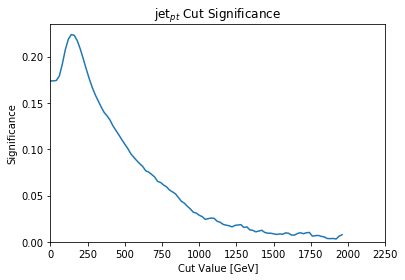

In [60]:
plot_cut_efficiency('',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif3' )

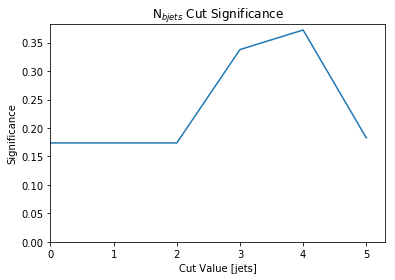

In [61]:
plot_cut_efficiency('',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif3')

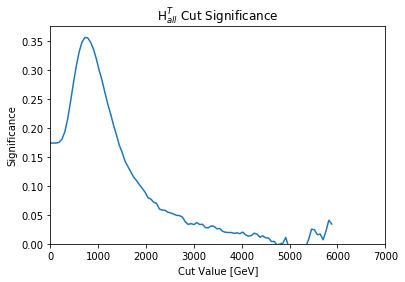

In [62]:
plot_cut_efficiency('',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif3')

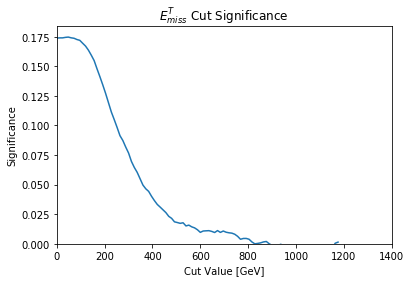

In [63]:
plot_cut_efficiency('', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif3')

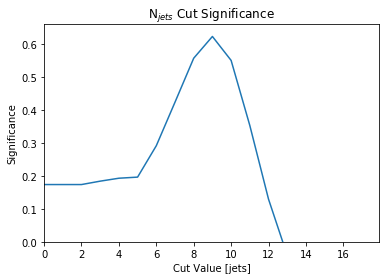

In [64]:
plot_cut_efficiency('', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif3')

# AFTER FOURTH CUT (CUT ON XX)

In [11]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

cut1 = ['bjets_mc70 <=2', 'njets < 9']
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, cuts = cut1, poly=fit_fn)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True, cuts=cut1)

bjets_mc70 <=2
njets < 9
10
10
9
10
9
10
10
11
10
9
9
9
9
14
11
10
10
11
10
10
9
9
10
9
12
9
11
9
9
9
9
10
12
11
10
9
9
10
9
10
9
9
9
11
9
9
12
9
13
9
9
9
9
12
10
10
9
11
9
9
9
10
10
9
9
9
12
11
10
9
9
11
9
10
10
12
9
9
9
9
9
12
9
9
10
12
11
11
10
9
10
11
15
9
11
9
13
10
9
12
9
10
10
11
12
9
13
10
12
9
10
11
10
10
10
10
11
9
11
9
12
12
13
9
12
9
9
12
11
9
10
10
11
9
9
9
9
9
10
9
10
10
10
9
13
10
10
10
14
13
12
11
10
9
10
9
10
9
11
10
10
10
11
10
9
12
10
10
9
11
10
10
10
10
9
10
9
12
10
11
12
9
9
9
13
11
11
12
9
11
10
9
9
10
12
12
13
9
11
9
11
10
9
10
9
9
12
11
9
11
11
15
10
9
14
9
11
9
11
11
10
9
9
9
11
10
10
13
10
10
9
10
12
9
11
10
12
12
9
9
11
11
9
12
9
12
9
9
10
9
9
11
11
12
12
10
11
9
10
10
9
10
11
10
12
11
9
14
12
9
9
9
9
10
9
12
10
10
10
11
12
10
12
12
9
11
10
9
11
9
11
9
9
9
10
9
11
10
10
10
13
9
11
10
9
9
11
12
11
9
9
10
9
15
11
10
9
10
9
13
10
13
12
9
9
11
11
11
10
10
10
11
13
11
9
9
10
9
11
9
10
9
10
10
10
9
9
9
10
10
9
9
10
9
12
11
10
9
10
10
9
12
9
9
11
9
10
11
9
9
11
11
9

KeyboardInterrupt: 

In [13]:
for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file ht_all_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file bjets_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file njets_sig_bkg_19-05-01+00_05.root has been created


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


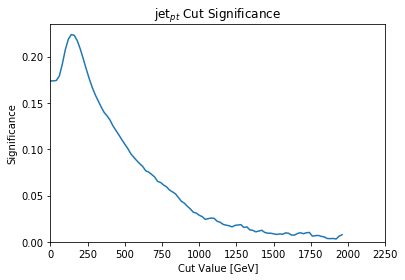

In [60]:
plot_cut_efficiency('',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif4' )

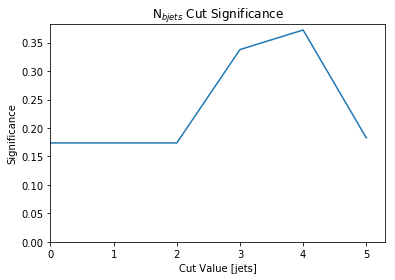

In [61]:
plot_cut_efficiency('',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif4')

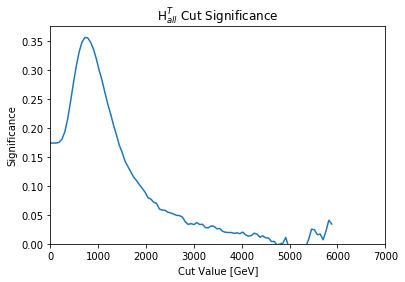

In [62]:
plot_cut_efficiency('',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif4')

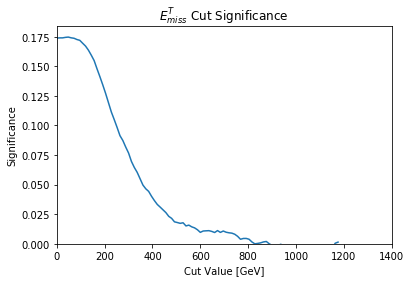

In [63]:
plot_cut_efficiency('', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif4')

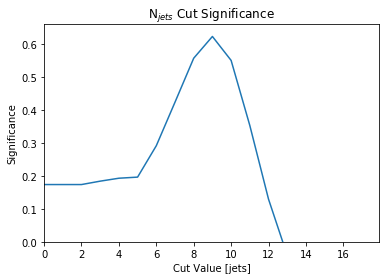

In [64]:
plot_cut_efficiency('', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif4')

# AFTER FIFTH CUT (CUT ON XX)

In [11]:
%%time
f_ratio = r.TFile('ht_fit_correct.root')
h_ratio = f_ratio.Get('ht_all_bkg;1')
fit_fn = h_ratio.GetFunction('pol5')

cut1 = ['bjets_mc70 <=2', 'njets < 9']
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True, cuts = cut1, poly=fit_fn)
fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = fit_fn, save_hists=True, cuts=cut1)

bjets_mc70 <=2
njets < 9
10
10
9
10
9
10
10
11
10
9
9
9
9
14
11
10
10
11
10
10
9
9
10
9
12
9
11
9
9
9
9
10
12
11
10
9
9
10
9
10
9
9
9
11
9
9
12
9
13
9
9
9
9
12
10
10
9
11
9
9
9
10
10
9
9
9
12
11
10
9
9
11
9
10
10
12
9
9
9
9
9
12
9
9
10
12
11
11
10
9
10
11
15
9
11
9
13
10
9
12
9
10
10
11
12
9
13
10
12
9
10
11
10
10
10
10
11
9
11
9
12
12
13
9
12
9
9
12
11
9
10
10
11
9
9
9
9
9
10
9
10
10
10
9
13
10
10
10
14
13
12
11
10
9
10
9
10
9
11
10
10
10
11
10
9
12
10
10
9
11
10
10
10
10
9
10
9
12
10
11
12
9
9
9
13
11
11
12
9
11
10
9
9
10
12
12
13
9
11
9
11
10
9
10
9
9
12
11
9
11
11
15
10
9
14
9
11
9
11
11
10
9
9
9
11
10
10
13
10
10
9
10
12
9
11
10
12
12
9
9
11
11
9
12
9
12
9
9
10
9
9
11
11
12
12
10
11
9
10
10
9
10
11
10
12
11
9
14
12
9
9
9
9
10
9
12
10
10
10
11
12
10
12
12
9
11
10
9
11
9
11
9
9
9
10
9
11
10
10
10
13
9
11
10
9
9
11
12
11
9
9
10
9
15
11
10
9
10
9
13
10
13
12
9
9
11
11
11
10
10
10
11
13
11
9
9
10
9
11
9
10
9
10
10
10
9
9
9
10
10
9
9
10
9
12
11
10
9
10
10
9
12
9
9
11
9
10
11
9
9
11
11
9

KeyboardInterrupt: 

In [13]:
for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg_corr,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

Info in <THStack::SaveAs>: ROOT file met_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file jet_pt_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file ht_all_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file bjets_sig_bkg_19-05-01+00_05.root has been created
Info in <THStack::SaveAs>: ROOT file njets_sig_bkg_19-05-01+00_05.root has been created


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [41]:
find_opt_cut('')

Cut at 9.0 for significance = 0.6234426076611024


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


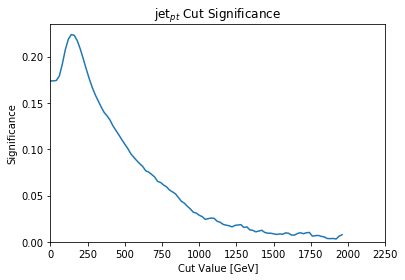

In [60]:
plot_cut_efficiency('',title = r'jet$_{pt}$ Cut Significance',unit = 'GeV', save_name='jetpt_signif5' )

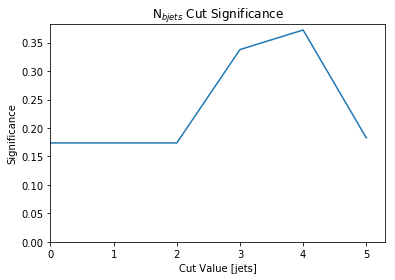

In [61]:
plot_cut_efficiency('',title = r'N$_{bjets}$ Cut Significance', unit='jets',save_name='bjets_signif5')

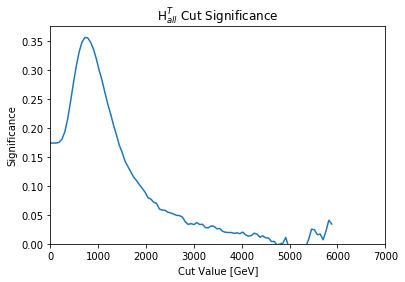

In [62]:
plot_cut_efficiency('',title = r'H$^T_{all}$ Cut Significance', unit='GeV',save_name='ht_signif5')

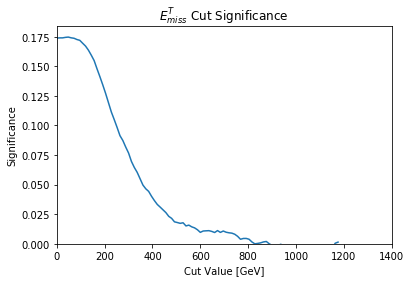

In [63]:
plot_cut_efficiency('', title = r'$E^T_{miss}$ Cut Significance',unit = 'GeV', save_name='met_signif5')

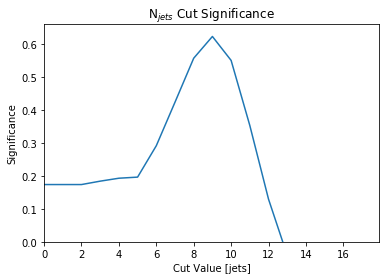

In [64]:
plot_cut_efficiency('', unit = 'jets', title = r'N$_{jets}$ Cut Significance', save_name='njets_signif5')

# Make FINAL Signal Background Plots

In [7]:
def make_bkg_sig_from_file(file):
    f = r.TFile(file)
    stack = f.Get(";1")
    
    f.Close()
    hists = stack.GetHists()
    
    bkg, sig = hists
    bkg.SetDirectory(0)
    sig.SetDirectory(0)
    
    bkg.Draw()
    bkg.SetLineColor(4)
    sig.Draw("SAME")
    sig.SetLineColor(2)
    
    leg = r.TLegend()
    leg.AddEntry(bkg, 'Background')
    leg.AddEntry(sig, 'Signal')

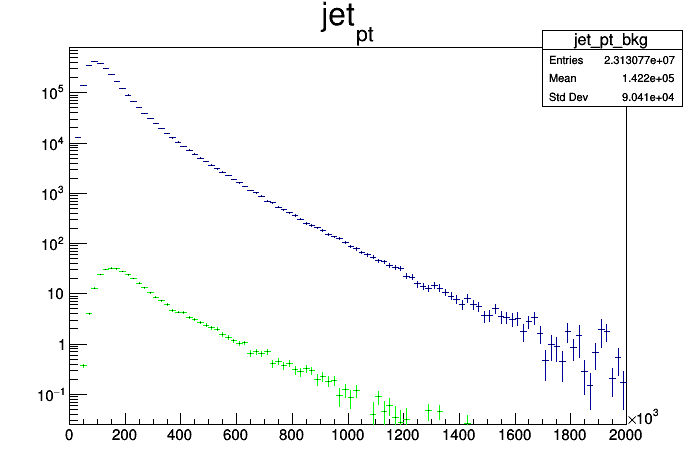

In [21]:
file = 'jet_pt_sig_bkg_19_04_17+19_30.root'
f = r.TFile(file)
stack = f.Get(";1")

f.Close()
hists = stack.GetHists()

bkg, sig = hists
bkg.SetDirectory(0)
sig.SetDirectory(0)

c = r.TCanvas()
bkg.Draw()

bkg.SetLineColor(4)
sig.Draw("SAME")
sig.SetLineColor(2)

bkg.SetTitle('jet_{pt} Signal vs Background')
bkg.SetXTitle('[MeV]')
bkg.SetYTitle('Events')
bkg.SetStat(0)

c.SetLogy()
c.Draw()
